# Exploration of the London Bike Shares dataset

This notebook outlines the exploration of a dataset of London bike share usage available at [kaggle](https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset). The purpose of this notebook is to find potentially interesting relationships in the dataset to further explore in a visualization application.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cleaning import clean_data, format_datetimes

In [2]:
sns.set_palette('Set2')

Read and clean up the data set.

In [3]:
df = pd.read_csv('data/clean_data.csv')
df['timestamp'] = format_datetimes(df)
df.set_index('timestamp', inplace=True)

## Overview

This section lays out an overview of the bike sharing data as a timeline graph. Both bike sharing data and weather data are aggregated over two week intervals plotted.

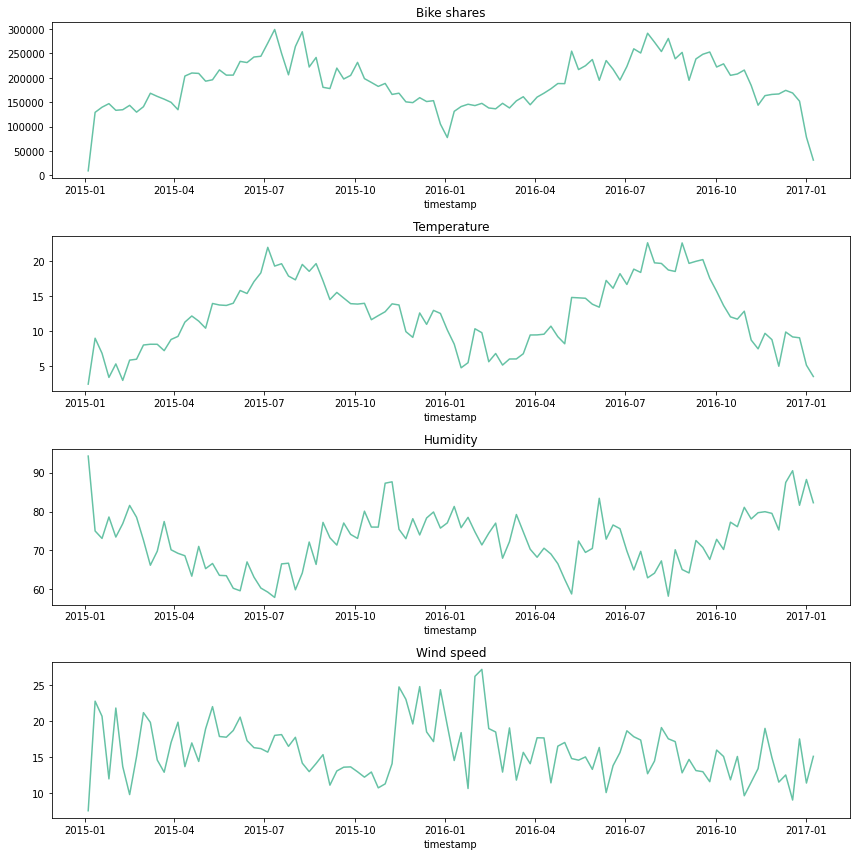

In [4]:
agg_freq = '1W'

counts = df['count'].groupby(pd.Grouper(freq=agg_freq)).sum()
temps = df['temp_real'].groupby(pd.Grouper(freq=agg_freq)).mean()
hums = df['humidity'].groupby(pd.Grouper(freq=agg_freq)).mean()
winds = df['wind_speed'].groupby(pd.Grouper(freq=agg_freq)).mean()

fig, axes = plt.subplots(4, 1)
fig.set_figheight(12)
fig.set_figwidth(12)
axes[0].set_title('Bike shares')
sns.lineplot(x=counts.index, y=counts.values, ax=axes[0])
axes[1].set_title('Temperature')
sns.lineplot(x=temps.index, y=temps.values, ax=axes[1])
axes[2].set_title('Humidity')
sns.lineplot(x=hums.index, y=hums.values, ax=axes[2])
axes[3].set_title('Wind speed')
sns.lineplot(x=winds.index, y=winds.values, ax=axes[3])
plt.tight_layout()

## Correlations in weather data

To get a better understanding of statistical properties of the weather data, a pair-wise multi scatter plot is created. Here it can be noted that while there is a strong correlation between real temperature (`temp_real`) and experienced temperature (`temp_feels`), the other variables are weakly correlated at best. As such, they may all be interesting to investigate further.

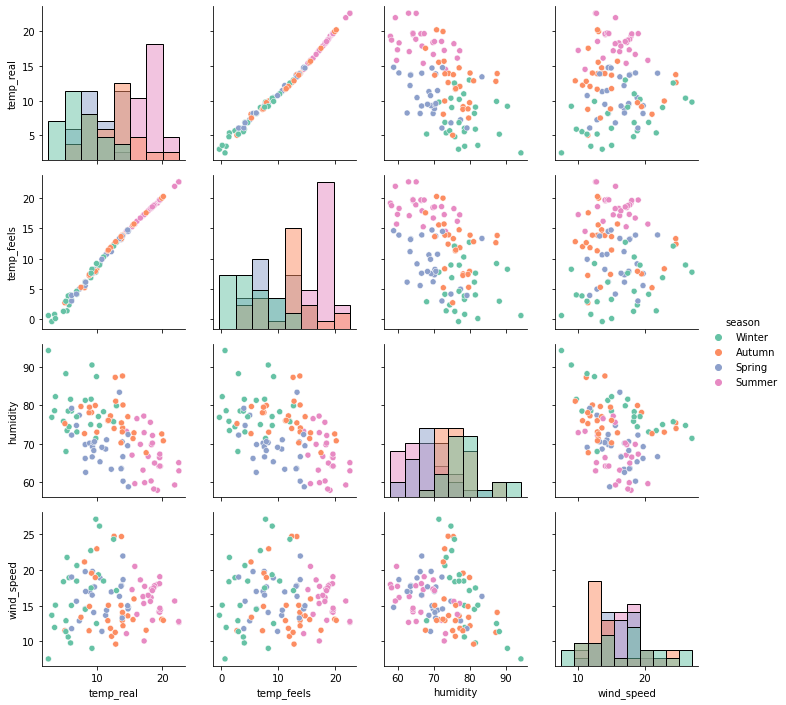

In [5]:
mean_agg = df[['temp_real', 'temp_feels', 'humidity', 'wind_speed', 'season']].groupby(pd.Grouper(freq=agg_freq)).mean()

season_key = ['Spring', 'Summer', 'Autumn', 'Winter']
seasons = mean_agg['season'].apply(lambda x: int(np.floor(x))).apply(lambda x: season_key[x])
mean_agg['season'] = seasons

g = sns.PairGrid(mean_agg, hue='season')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## Correlations between bike usage and weather data

Possible correlations between weather data and aggregated bike usage (using the same time intervals as in previous sections) is explored.

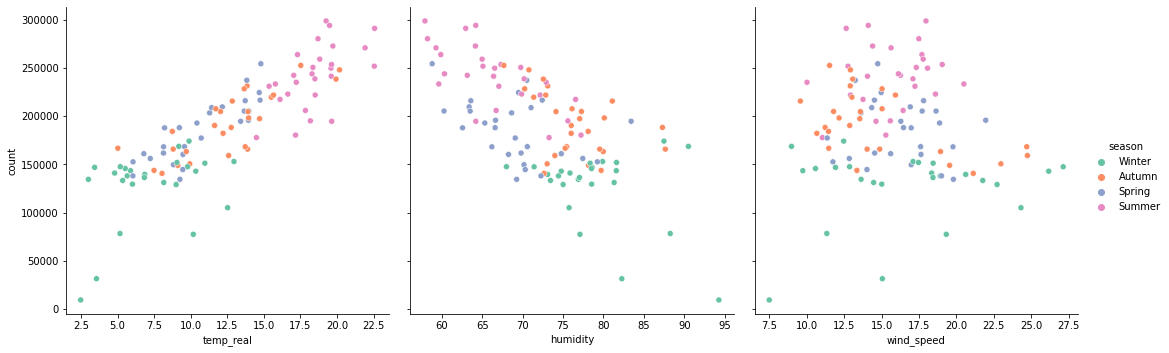

In [6]:
weather_counts = mean_agg[['temp_real', 'humidity', 'wind_speed', 'season']].join(counts)

g = sns.PairGrid(weather_counts, x_vars=['temp_real', 'humidity', 'wind_speed'], y_vars='count', hue='season', height=5)
g.map(sns.scatterplot)
g.add_legend()

A general distribution of the bike share data grouped by season is given below.

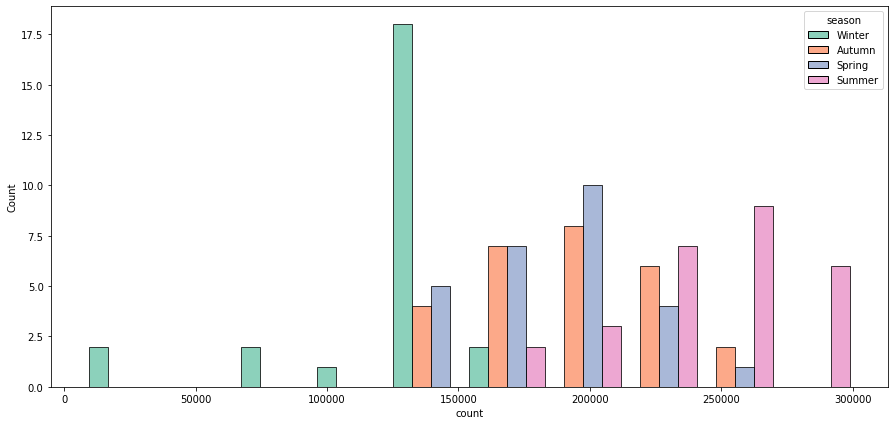

In [7]:
g = sns.histplot(pd.concat([counts,seasons], axis=1), x='count', hue='season', multiple='dodge')
g.figure.set_figwidth(15)
g.figure.set_figheight(7)

## Querying and aggregating on a 24 hour basis

In this section, we approach the problem of selecting specific parts of the dataset. We filter based on some of the categorical fields (e.g. `is_weekend`, `weather_code` and `season`) to obtain a subset which is then aggregated to get distributions over a 24 hour period. An example use-case for this would be find the hourly distribution of bike usage on weekends when the weather is rainy.

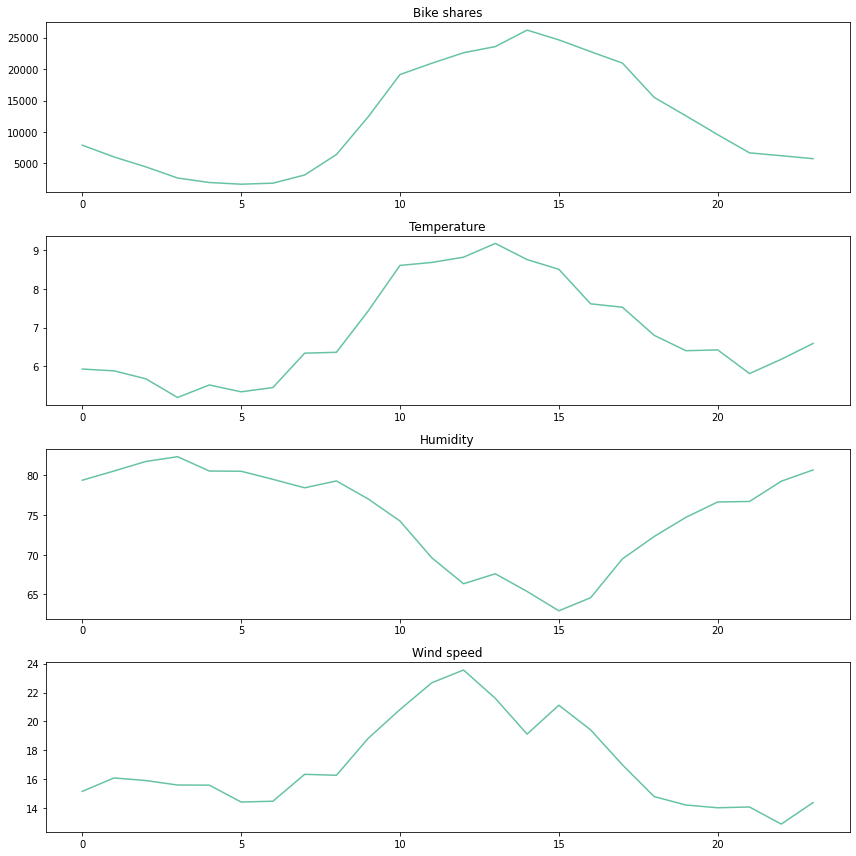

In [8]:
query_str = 'is_weekend == 1 & weather_code in (1, 2) & season == 3'
qdf = df.query(query_str)

count_hours = qdf['count'].groupby(qdf.index.time).sum()
weather_hours = qdf[['temp_real', 'humidity', 'wind_speed']].groupby(qdf.index.time).mean()

fig, axes = plt.subplots(4, 1)
fig.set_figheight(12)
fig.set_figwidth(12)
axes[0].set_title('Bike shares')
axes[0].plot(count_hours.values)
axes[1].set_title('Temperature')
axes[1].plot(weather_hours['temp_real'].values)
axes[2].set_title('Humidity')
axes[2].plot(weather_hours['humidity'].values)
axes[3].set_title('Wind speed')
axes[3].plot(weather_hours['wind_speed'].values)
plt.tight_layout()